In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error

### Functions 
To look at the amounts and proportions of null values I made this `null_table()` function. Give it a dataframe and it will output a table of the columns with a count of missing values, their dtypes, and what percent of the values in that column are missing. The additional helper function `perc()` will convert a number to a nicely formatted string with the amout of trailing zeros you desire. E.g. `perc(0.54432, 2)` returns `'54%'`.

In [3]:
# Give it a number and how many decimal places you want and it will give you
# a pretty string of what percent it is.
def perc(number, decimals = 0):
    x100 = number * 100
    rounded = round(x100, decimals)
    # I do the int() because otherwise '1' will still print as '1.0'
    if decimals == 0:
        rounded = int(rounded)
    # It will also round to 0 if the value is small, so in that case
    # I will allow a few decimals to get '0.01%'
    if rounded == 0:
        rounded = round(x100, 2)
    # If it's still coming out less than 0.01 then return '<0.01%
    if rounded == 0:
        rounded = '< 0.01'
    return f'{rounded}%'

# Makes a nice little table of which features have nulls, their dtypes, 
# and the percent rows in the sheet that have nulls from that feature - 
# and thus how much of the datafarame you'd loose by dropping them.

def null_table(df):
    # this line cribbed from Devin Fay in lesson 4.05
    df_nulls = df.isnull().sum().sort_values(ascending=False).loc[lambda x: x > 0]
    null_perc = df_nulls/df.shape[0]
    null_perc = null_perc.apply(perc)
    df_summary = pd.concat([df_nulls, df.dtypes, null_perc], join = 'inner', axis=1, copy=True)
    df_summary.columns = ['NAs', 'dtype', 'perc']
    df_summary.reindex(columns = ['dtype', 'NAs', 'perc'])
    return df_summary

### Import / Prepare Files

The naming scheme for the base objects is:
* `ames_raw`: Just the `train.csv` file itself, without modification.
* `ames_prep`: Just `ames_raw` with column names formatted in a tidy manner.
* `ames_test_raw`: Just the `test.csv` itself, without modification.
* `ames_test_prep`: Just `ames_test_raw` with column names formatted in a tidy manner.

In [4]:
# `ames_raw` is just the file itself
# `ames_prep` is a basic reformatting of feature labels and nothing else

ames_raw = pd.read_csv('./datasets/train.csv')
ames_prep = ames_raw
ames_prep.columns = ames_prep.columns.str.lower()
ames_prep.columns = ames_prep.columns.str.replace(' ', '_')
ames_prep.columns = ames_prep.columns.str.replace('/', '_')
print('Verify import by looking at the dimensions of the dataframes:')
print(f'ames_prep.shape -> {ames_prep.shape}')

# `ames_test_raw` is just the file itself
# `ames_test_prep` is a basic reformatting of feature labels and nothing else
ames_test_raw = pd.read_csv('./datasets/test.csv')
ames_test_prep = ames_test_raw
ames_test_prep.columns = ames_test_prep.columns.str.lower()
ames_test_prep.columns = ames_test_prep.columns.str.replace(' ', '_')
ames_test_prep.columns = ames_test_prep.columns.str.replace('/', '_')
print(f'ames_test_prep.shape -> {ames_test_prep.shape}')

Verify import by looking at the dimensions of the dataframes:
ames_prep.shape -> (2051, 81)
ames_test_prep.shape -> (878, 80)


## Preprocessing
### Uninformative columns and outliers I removed:
* The first two columns `id` and `pid` are indexing features - they have a unique value for each entry
* Sparse features with too few values to be useful:<br>`pool_qc`, `misc_feature`, `pool_area`, `alley`, `fence`, `fireplace_qu`, `lot_frontage`
* `DataDocumentation.txt`([link](./datasets/DataDocumentation.txt)) indicates there are some outlier observations with sale prices oddly low for their ground floor living area. These correspond to `pid: 908154235` and `pid: 908154195` (see plot below).
* Several numeric columns are filled, but have many zero values. This is because they refer to measurements of house features which aren't present in that actual house. Such as second floor square footage (`2nd_flr_sf`) being zero indicating there is no second floor. I will have to be mindful of this when using features like this as a zero value in this case doesn't carry useful information.

In [5]:
# Look for sparse features
null_table(ames_prep)

,NAs,dtype,perc
pool_qc,2042,object,100%
misc_feature,1986,object,97%
alley,1911,object,93%
fence,1651,object,80%
fireplace_qu,1000,object,49%
lot_frontage,330,float64,16%
garage_finish,114,object,6%
garage_qual,114,object,6%
garage_yr_blt,114,float64,6%
garage_cond,114,object,6%


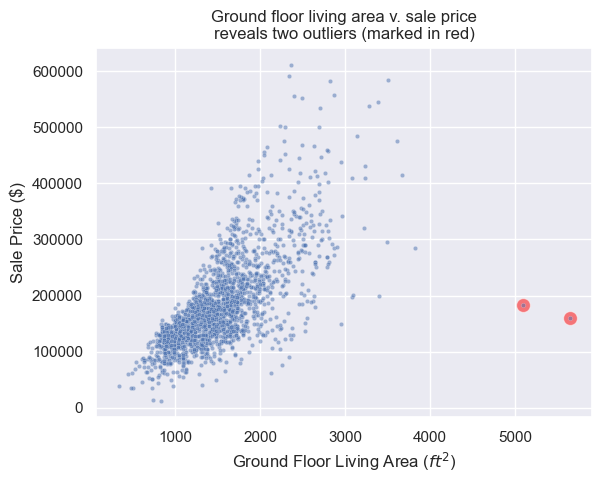

In [6]:
# Look for outliers mentioned in DataDescription.txt
sns.set_theme()
sns.scatterplot(data = ames_prep[(ames_prep['gr_liv_area'] > 5000)], x = 'gr_liv_area', y = 'saleprice', 
                markers = 'o', color = 'red', 
                s=100, alpha = 0.5)
sns.scatterplot(data = ames_prep, x = 'gr_liv_area', y = 'saleprice', 
                s=10, alpha = 0.5
               ).set(xlabel = 'Ground Floor Living Area ($ft^2$)',
                     ylabel = 'Sale Price ($)',
                     title = 'Ground floor living area v. sale price\nreveals two outliers (marked in red)');

In [7]:
# Look for numeric features with 0's
numeric_cols = ames_prep.select_dtypes(include='number').columns.tolist()
zero_counts = []
for col in numeric_cols:
        zero_counts.append(ames_prep[col].value_counts().get(0, 0))

zero_counts = pd.DataFrame({'column': numeric_cols, 'num_zeros': zero_counts})
zero_counts = zero_counts.sort_values(by = 'num_zeros', ascending = False)
zero_counts.query('num_zeros > 0')

,column,num_zeros
34,pool_area,2042
32,3ssn_porch,2025
16,low_qual_fin_sf,2018
35,misc_val,1986
19,bsmt_half_bath,1923
33,screen_porch,1870
11,bsmtfin_sf_2,1803
31,enclosed_porch,1724
21,half_bath,1308
9,mas_vnr_area,1216


In [8]:
# Remove the features mentioned above.
# `ames` and `ames_test` will be the sets I use for analysis and my submitted predictions respectively
ames = ames_prep
ames_test = ames_test_prep

# Outlier observations
outlier_obervations_pid = [908154235, 908154195]

# Specific features to exclude
sparse_features = ['pool_qc', 'misc_feature', 'pool_area', 'alley', 'fence', 'fireplace_qu', 'lot_frontage']
index_features = ['id', 'pid']

# Drop outliers from training set
ames = ames[~ames['pid'].isin(outlier_obervations_pid)]

# Drop uninformative features from training and test
ames = ames.drop(columns = sparse_features + index_features)
ames_test = ames_test.drop(columns = sparse_features + index_features)

## EDA / Feature Engineering I
The year the home was built has a correlation with the price, especially for homes under 25 years of age. There is also data on remodelings which have been done, but it's recorded as the year the remodel (or addition) was done, and if there has been no remodel it's just recorded as the year the home was built. There seems to be some tendency in the data to favor homes which have been remodeled more recently, but the variance is high. One problem is because the `year_remod_add` feature doesn't directly indicate whether the home has had a remodel, it's just implied by the year of the remodel being identical to the year the home was built.
<br><br>To get around this, I created a new feature `eng_remodel_x_built` which is the two features multiplied together. This has a large value when the home was built recently or has had a recent remodeling. Older home with recent remodels will also get a higher value than they would otherwise, and older homes without the remodel will have the lowest values. This feature looks to have a slightly better correlation with price.

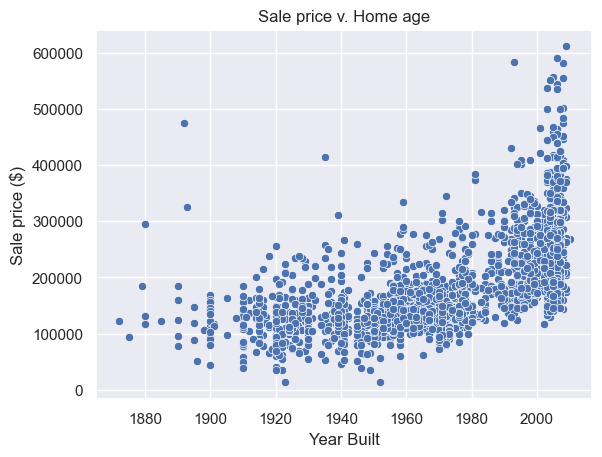

In [9]:
sns.scatterplot(data = ames_prep, x = 'year_built', y = 'saleprice'
               ).set(title = "Sale price v. Home age",
                xlabel = 'Year Built',
                ylabel = 'Sale price ($)');

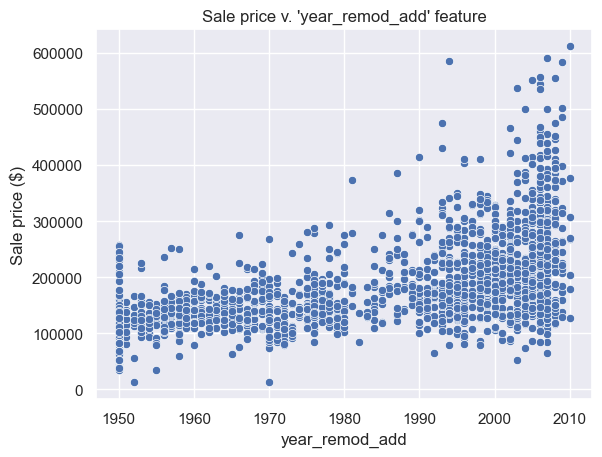

In [10]:
ames_eda = ames_prep
sns.scatterplot(data = ames_eda, x = 'year_remod_add', y = 'saleprice'
               ).set(title = "Sale price v. 'year_remod_add' feature",
                xlabel = 'year_remod_add',
                ylabel = 'Sale price ($)');

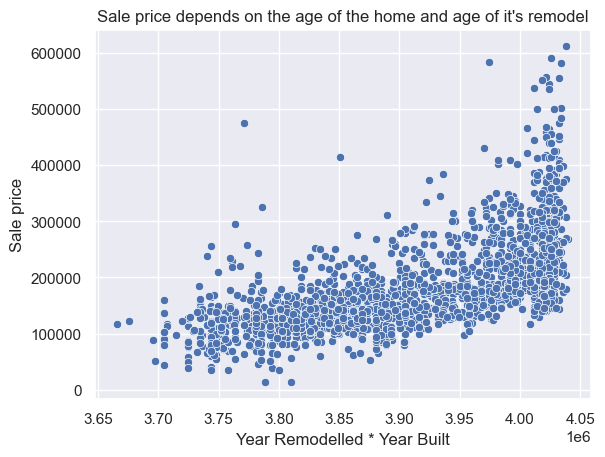

In [11]:
# make a feature combinging year built and year remodelled - add this in to dataset
ames_eda['eng_remodel_x_built'] = ames_eda['year_remod_add'] * ames_eda['year_built']
sns.scatterplot(data = ames_eda, x = 'eng_remodel_x_built', y = 'saleprice'
               ).set(title = "Sale price depends on the age of the home and age of it's remodel",
                xlabel = 'Year Remodelled * Year Built',
                ylabel = 'Sale price');

### Feature Engineering II - Ordinal Encoding
* I made `feature_info.csv`([link](./datasets/feature_info.csv)) by hand from `DataDocumentation.txt`([link](./datasets/DataDocumentation.txt)) to link the data types specified in the description to the column names. This is more accurate than the `.dtypes`. For example ordinal features will get a numeric dtype when they should be interpreted as a string. Likewise discrete features will get a `float_64` dtype if they contain null values. Working from `feature_info.csv` I can engineer features appropriately without relying on the dtypes inferred by `pd.read_csv'.
* Each ordinal feature had it's recorded values replaces with a numeric value starting with 0 for the lowest ranked value.
* In cases where the ordinal feature is scoring something the home in question doesn't have (such as basement condition for a home without a basement), the score is recorded as 'NA'. This is problematic because it will result in the absence of a feature equated with a low quality feature. Since I plan on imputing NA's/Null values anyway, I left those values untouched so they can be picked up by the imputation process.

Resources I used/cribbed from:<br>
[Source 1](https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f), 
[Source 2](https://towardsdatascience.com/using-sklearn-pipelines-to-streamline-your-machine-learning-process-a27721fdff1b)

In [12]:
# This file has some column descriptions I pulled from `./datasets/DataDocumentation.txt`.
# `column_name` is the feature/column names from the test/train.csv's
# `data_type` is the type of data (Discrete, Continuous, Nominal, Ordinal)
# `data_description` is a description of that datapoint
feature_info = pd.read_csv('./datasets/feature_info.csv')
feature_info['column_name'] = feature_info['column_name'].str.lower()
feature_info['column_name'] = feature_info['column_name'].str.replace(' ', '_')
feature_info['column_name'] = feature_info['column_name'].str.replace('/', '_')

# this is a dataframe of the `dtypes` for each column
dtypes_df = pd.DataFrame(ames_prep.dtypes).reset_index()
dtypes_df.columns = ['column_name', 'dtype']

# merge this in with feature_info so I have a table of each feature's properties
feature_info = feature_info.merge(dtypes_df)
feature_info = feature_info.reindex(columns=['column_name', 'data_type', 'dtype', 'data_description'])

In [13]:
# Ordinal Feature Mappings
# I tried to used OrdianalEncoder for this but it wasn't working for me, so I am doing it manually...

# Many ordinal features are encoded with this common_mapping:
# 'Poor', 'Fair', 'Typical', 'Good', 'Excellent'
common_mapping = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
ord_features_with_common_mapping = \
["exter_qual", "exter_cond", "bsmt_qual", "bsmt_cond", "kitchen_qual", "garage_qual", "garage_cond", 'heating_qc']

# paved_drive is encoded like this:
# 'None', 'Partial', 'Yes'
paved_mapping = {'N': 0, 'P': 1, 'Y': 2}

# Home functionality (column: 'functional') is encoded like this:
# 'Salvage only', 'Severely Damaged', 'Major Deductions 2', 'Major Deductions 1', 'Moderate Deductions', 
# 'Minor Deductions 2', 'Minor Deductions 1', 'Typical Functionality'
functional_mapping = {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7}

# Lot shape
lot_shape_mapping = {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
# Utilities
utilities_mapping = {'ELO': 0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3}
# Land Slope
land_slope_mapping = {'Sev': 0, 'Mod': 1, 'Gtl': 2}
# Overall Quality
overall_qual_mapping = {'Very Poor': 0, 'Poor': 1, 'Fair': 2, 'Below Average': 3, 'Average': 4, 'Above Average': 5, 'Good': 6, 'Very Good': 7, 'Excellent': 8, 'Very Excellent': 9}
# Overall Condition (same as overall quality)
overall_cond_mapping = overall_qual_mapping
# Basement Exposure - 
# there is an 'NA' level used in the dataset to indicate there is no 
# basement, I will leave that as is so the imputation will catch it 
bsmt_exposure_mapping = {'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
# BsmtFin Type 1
# there is an 'NA' level used in the dataset to indicate there is no 
# basement, I will leave that as is so the imputation will catch it 
bsmtfin_type_1_mapping = {'Unf': 0, 'LwQ': 1, 'Rec': 2, 'BLQ': 3, 'ALQ': 4, 'GLQ': 5}
# BsmtFin Type 2
# there is an 'NA' level used in the dataset to indicate there is no 
# basement, I will leave that as is so the imputation will catch it 
bsmtfin_type_2_mapping = bsmtfin_type_1_mapping 
# Heating QC
heating_qc_mapping = common_mapping
# Electrical
electrical_mapping = {'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4}
# Garage Finish
# there is an 'NA' level used in the dataset to indicate there is no 
# basement, I will leave that as is so the imputation will catch it 
garage_finish_mapping = {'Unf': 0, 'RFn': 1, 'Fin': 2}

# Replace string ordinals with numeric
ames[ord_features_with_common_mapping] = ames[ord_features_with_common_mapping].replace(common_mapping)
ames['paved_drive'] = ames['paved_drive'].replace(paved_mapping)
ames['functional'] = ames['functional'].replace(functional_mapping)
ames['lot_shape'] = ames['lot_shape'].replace(lot_shape_mapping) 
ames['utilities'] = ames['utilities'].replace(utilities_mapping)
ames['land_slope'] = ames['land_slope'].replace(land_slope_mapping)
ames['overall_qual'] = ames['overall_qual'].replace(overall_qual_mapping)
ames['overall_cond'] = ames['overall_cond'].replace(overall_cond_mapping)
ames['bsmt_exposure'] = ames['bsmt_exposure'].replace(bsmt_exposure_mapping)
ames['bsmtfin_type_1'] = ames['bsmtfin_type_1'].replace(bsmtfin_type_1_mapping)
ames['bsmtfin_type_2'] = ames['bsmtfin_type_2'].replace(bsmtfin_type_2_mapping)
ames['electrical'] = ames['electrical'].replace(electrical_mapping)
ames['garage_finish'] = ames['garage_finish'].replace(garage_finish_mapping)

ames_test[ord_features_with_common_mapping] = ames_test[ord_features_with_common_mapping].replace(common_mapping)
ames_test['paved_drive'] = ames_test['paved_drive'].replace(paved_mapping)
ames_test['functional'] = ames_test['functional'].replace(functional_mapping)
ames_test['lot_shape'] = ames_test['lot_shape'].replace(lot_shape_mapping) 
ames_test['utilities'] = ames_test['utilities'].replace(utilities_mapping)
ames_test['land_slope'] = ames_test['land_slope'].replace(land_slope_mapping)
ames_test['overall_qual'] = ames_test['overall_qual'].replace(overall_qual_mapping)
ames_test['overall_cond'] = ames_test['overall_cond'].replace(overall_cond_mapping)
ames_test['bsmt_exposure'] = ames_test['bsmt_exposure'].replace(bsmt_exposure_mapping)
ames_test['bsmtfin_type_1'] = ames_test['bsmtfin_type_1'].replace(bsmtfin_type_1_mapping)
ames_test['bsmtfin_type_2'] = ames_test['bsmtfin_type_2'].replace(bsmtfin_type_2_mapping)
ames_test['electrical'] = ames_test['electrical'].replace(electrical_mapping)
ames_test['garage_finish'] = ames_test['garage_finish'].replace(garage_finish_mapping)

### Feature Engineering III - Imputation
* Normally the simplest thing to do with missing values in observations is simply to remove those observations form the dataset. However, since `test.csv` has it's own missing values, and I need to predict each observation to submit to Kaggle, a uniform imputation scheme seems the most elegant solution.
* For continuous numeric values I replaced the missing values with the median value and for categorical, ordinal, and discrete numeric features I replaced with the most frequent value (the mode). 
* Test and training sets were made before this imputation to prevent data leakage. Note: `X_test` is not to be confused with `ames_test`. `X_test` is the result of a `train_test_split()` from the `train.csv` file. The data from `test.csv` is kept in `ames_test` and will get all of the same transformations as the other datasets.
* Seperate imputers were made for the each kind of data and applied to columns based on the mappings in `feature_info.csv`([link](./datasets/feature_info.csv)).

In [14]:
# X and y are the training data from train.csv
X = ames.drop(columns = 'saleprice')
y = ames['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=17)

In [15]:
# Get a list of all the 'Continuous' features in the dataset
continuous_numeric_features = feature_info.query("data_type == 'Continuous'")['column_name'].to_list()
# From this remove all the features which I have already removed
continuous_numeric_features = [x for x in continuous_numeric_features if x in X.columns.to_list()]

# Do the imputation on these columns
continuous_numeric_imputer = SimpleImputer(strategy = 'median')
X_train[continuous_numeric_features] = continuous_numeric_imputer.fit_transform(X_train[continuous_numeric_features])

In [16]:
# Get a list of all the 'Discrete' features in the dataset
discrete_numeric_features = feature_info.query("data_type == 'Discrete'")['column_name'].to_list()
# From this remove all the features which I have already removed
discrete_numeric_features = [x for x in discrete_numeric_features if x in X.columns.to_list()]

# Do the imputation on these columns
discrete_numeric_imputer = SimpleImputer(strategy = 'most_frequent')
X_train[discrete_numeric_features] = discrete_numeric_imputer.fit_transform(X_train[discrete_numeric_features])

In [17]:
# Get a list of all the 'Nominal' (categorical) features in the dataset
categorical_features = feature_info.query("data_type == 'Nominal'")['column_name'].to_list()
# From this remove all the features which I have already removed
categorical_features = [x for x in categorical_features if x in X.columns.to_list()]

# Do the imputation on these columns
categorical_imputer = SimpleImputer(strategy = 'most_frequent')
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])

In [18]:
# Get a list of all the 'Ordinal' features in the dataset
ordinal_features = feature_info.query("data_type == 'Ordinal'")['column_name'].to_list()
# From this remove all the features which I have already removed
ordinal_features = [x for x in ordinal_features if x in X.columns.to_list()]

# Do the imputation on these columns
ordinal_imputer = SimpleImputer(strategy = 'most_frequent')
X_train[ordinal_features] = ordinal_imputer.fit_transform(X_train[ordinal_features])

In [19]:
# Now impute test set
X_test[continuous_numeric_features] = continuous_numeric_imputer.transform(X_test[continuous_numeric_features])
X_test[discrete_numeric_features] = discrete_numeric_imputer.transform(X_test[discrete_numeric_features])
X_test[categorical_features] = categorical_imputer.transform(X_test[categorical_features])
X_test[ordinal_features] = ordinal_imputer.transform(X_test[ordinal_features])

In [20]:
# Now impute kaggle submission test set
ames_test[continuous_numeric_features] = continuous_numeric_imputer.transform(ames_test[continuous_numeric_features])
ames_test[discrete_numeric_features] = discrete_numeric_imputer.transform(ames_test[discrete_numeric_features])
ames_test[categorical_features] = categorical_imputer.transform(ames_test[categorical_features])
ames_test[ordinal_features] = ordinal_imputer.transform(ames_test[ordinal_features])

In [21]:
# Make an impute X for RMSE calculations
X[continuous_numeric_features] = continuous_numeric_imputer.transform(X[continuous_numeric_features])
X[discrete_numeric_features] = discrete_numeric_imputer.transform(X[discrete_numeric_features])
X[categorical_features] = categorical_imputer.transform(X[categorical_features])
X[ordinal_features] = ordinal_imputer.transform(X[ordinal_features])

### Feature Engineering IV - Summative Measurements
Several discrete and numeric features contain counts or areas of rooms, bedrooms, bathrooms or floors of the home. This presents a similar problem as the "NA" levels of some ordinal features, they imply a zero value where an NA would be more appropriate. For example, `bsmt_unf_sf` indicates area of unfinished space in a basement, but this will be zero in homes with entirely finished basements or no basement at all. This could be fixed with encoding, but that adds a lot of complexity, especially when these features may only each contribute a small amount to the explainatory power of the model. <br><br>
To try and get around this and create features which more wholly represent the size of the homes, I created 3 more features which are summations of other features:
* `eng_total_indoor_sqft` - Total sqft on all floors, and garages, finished or otherwise.
* `eng_num_baths` - Number of baths and half-baths (with a half-bath being 0.5 bathrooms)
* `eng_total_rooms` - Total number of rooms (including bathrooms). Note that this feature may be incomplete as `DataDescription.txt` doesn't include any basement bedrooms which might be present.
* `eng_remodel_x_built` - [Described above](#EDA-/-Feature-Engineering-I)


In [22]:
# Add in engineered features for X_train
# Polynomial feature combining year_built with year_remod_add
X_train['eng_remodel_x_built'] = X_train['year_remod_add'] * X_train['year_built']

# Feature of total indoot sqft
X_train['eng_total_indoor_sqft'] = X_train['1st_flr_sf'] \
                                + X_train['2nd_flr_sf'] \
                                + X_train['bsmtfin_sf_1'] \
                                + X_train['bsmtfin_sf_2'] \
                                + X_train['bsmt_unf_sf'] \
                                + X_train['garage_area']

# Total bathrooms (with half-bath being 0.5 bathrooms)
X_train['eng_num_baths'] = X_train['full_bath'] \
                        + (X_train['half_bath']/2)\
                        + X_train['bsmt_full_bath']\
                        + (X_train['bsmt_half_bath']/2)

# Total rooms (including bathrooms)
X_train['eng_total_rooms'] = X_train['eng_num_baths'] + X_train['totrms_abvgrd']

# List of these new features
engineered_features = ['eng_remodel_x_built', 'eng_total_indoor_sqft',\
                       'eng_total_rooms', 'eng_num_baths']

In [23]:
# Add in engineered features for X_test
# Polynomial feature combining year_built with year_remod_add
X_test['eng_remodel_x_built'] = X_test['year_remod_add'] * X_test['year_built']

# Feature of total indoot sqft
X_test['eng_total_indoor_sqft'] = X_test['1st_flr_sf'] \
                                + X_test['2nd_flr_sf'] \
                                + X_test['bsmtfin_sf_1'] \
                                + X_test['bsmtfin_sf_2'] \
                                + X_test['bsmt_unf_sf'] \
                                + X_test['garage_area']

# Total bathrooms (with half-bath being 0.5 bathrooms)
X_test['eng_num_baths'] = X_test['full_bath'] \
                        + (X_test['half_bath']/2)\
                        + X_test['bsmt_full_bath']\
                        + (X_test['bsmt_half_bath']/2)

# Total rooms (including bathrooms)
X_test['eng_total_rooms'] = X_test['eng_num_baths'] + X_test['totrms_abvgrd']

In [24]:
# Add in engineered features
# Polynomial feature combining year_built with year_remod_add
X['eng_remodel_x_built'] = X['year_remod_add'] * X['year_built']

# Feature of total indoot sqft
X['eng_total_indoor_sqft'] = X['1st_flr_sf'] \
                                + X['2nd_flr_sf'] \
                                + X['bsmtfin_sf_1'] \
                                + X['bsmtfin_sf_2'] \
                                + X['bsmt_unf_sf'] \
                                + X['garage_area']

# Total bathrooms (with half-bath being 0.5 bathrooms)
X['eng_num_baths'] = X['full_bath'] \
                        + (X['half_bath']/2)\
                        + X['bsmt_full_bath']\
                        + (X['bsmt_half_bath']/2)

# Total rooms (including bathrooms)
X['eng_total_rooms'] = X['eng_num_baths'] + X['totrms_abvgrd']

In [25]:
# Add in engineered features
# Polynomial feature combining year_built with year_remod_add
ames_test['eng_remodel_x_built'] = ames_test['year_remod_add'] * ames_test['year_built']

# Feature of total indoot sqft
ames_test['eng_total_indoor_sqft'] = ames_test['1st_flr_sf'] \
                                + ames_test['2nd_flr_sf'] \
                                + ames_test['bsmtfin_sf_1'] \
                                + ames_test['bsmtfin_sf_2'] \
                                + ames_test['bsmt_unf_sf'] \
                                + ames_test['garage_area']

# Total bathrooms (with half-bath being 0.5 bathrooms)
ames_test['eng_num_baths'] = ames_test['full_bath'] \
                        + (ames_test['half_bath']/2)\
                        + ames_test['bsmt_full_bath']\
                        + (ames_test['bsmt_half_bath']/2)

# Total rooms (including bathrooms)
ames_test['eng_total_rooms'] = ames_test['eng_num_baths'] + ames_test['totrms_abvgrd']

## Models

### Baseline Null Model
As a starting point we will model the saleprice as must the mean of all observed prices.
<br>$R^2 = 0$
<br>$RMSE = 79276.56$.

In [26]:
# Null Model
mean_saleprice = [y.mean()] * y.shape[0]
mean_saleprice_df = pd.DataFrame({'mean_saleprice': mean_saleprice,})

lr = LinearRegression()
lr.fit(mean_saleprice_df, y)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(mean_saleprice_df, y), 4)}')
preds = lr.predict(mean_saleprice_df)

mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    

LinearRegression()

         # Coef's:  1
      Train score:  0.0
             RMSE:  79276.56


### Model with continuous numeric features (17 coefficients)
For simplicity I next tried a model using all of the continuous numeric features. It is a huge improvement but still a poor fit.
<br>$R^2 = 0.78$
<br>$RMSE = 37385.8$

In [27]:
# Predicting with only continuous numeric features
selected_features = continuous_numeric_features

X_selected = X[selected_features]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lr = LinearRegression()
lr.fit(X_train_selected, y_train)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(X_train_selected, y_train), 4)}')
print(f'       Test score:  {round(lr.score(X_test_selected, y_test), 4)}')
preds = lr.predict(X_selected)
#preds.shape
mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cv_score = cross_val_score(lr, X_train_selected, y_train)
print(f'    Mean CV Score:  {round(cv_score.mean(), 2)}')
print(f'Cross Val. Scores: {cv_score}')

LinearRegression()

         # Coef's:  17
      Train score:  0.7882
       Test score:  0.7495
             RMSE:  37385.8
    Mean CV Score:  0.78
Cross Val. Scores: [0.76616152 0.73635947 0.83080467 0.78084043 0.78899173]


### Model adding in year built and several ordinal features (26 coefficients)
I added in the year and several ordinal features which used a common encoding  It is a huge improvement but still a poor fit.
<br>$R^2 = 0.78$
<br>$RMSE = 37385.8$

In [28]:
# Add in some commonly encoded ordinal features and the build year
selected_features = continuous_numeric_features \
                    + ord_features_with_common_mapping \
                    + ['year_built']

X_selected = X[selected_features]
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

lr = LinearRegression()
lr.fit(X_train_selected, y_train)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(X_train_selected, y_train), 4)}')
print(f'       Test score:  {round(lr.score(X_test_selected, y_test), 4)}')
preds = lr.predict(X_selected)
#preds.shape
mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cv_score = cross_val_score(lr, X_train_selected, y_train)
print(f'    Mean CV Score:  {round(cv_score.mean(), 2)}')
print(f'Cross Val. Scores: {cv_score}')
# got this from Devin's pipeline lesson
coefs = pd.DataFrame(
    data=lr.coef_,
    index=lr.feature_names_in_).sort_values(0)

# Uncomment this if you want to see the coefficients
#with pd.option_context('display.max_rows', None):
#    display(coefs)

LinearRegression()

         # Coef's:  26
      Train score:  0.8689
       Test score:  0.8584
             RMSE:  29012.83
    Mean CV Score:  0.86
Cross Val. Scores: [0.85324118 0.83502245 0.86870367 0.8753325  0.86902106]


In [29]:
# One Hot Encoding neighborhood
# Cribbed from transformers lesson

ohe = OneHotEncoder(
    drop = 'first',
    handle_unknown = 'ignore',
    sparse = False,
)

ctx = ColumnTransformer(
    transformers = [
        # alias, transformer, list of columns
        ('one_hot', ohe, ['neighborhood'])
    ], remainder = 'passthrough', #don't drop the other features
    verbose_feature_names_out=False
)

ctx.fit(X_train)

#recreate dataframes
X_train_enc = pd.DataFrame(
    ctx.transform(X_train),
    columns = ctx.get_feature_names_out()
)

X_test_enc = pd.DataFrame(
    ctx.transform(X_test),
    columns = ctx.get_feature_names_out()
)

X_enc = pd.DataFrame(
    ctx.transform(X),
    columns = ctx.get_feature_names_out()
)

#get these new column names
neighborhood_enc = X_train_enc.columns.to_list()
neighborhood_enc = [x for x in neighborhood_enc if x.startswith('neighborhood_')]

/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['neighborhood'])],
                  verbose_feature_names_out=False)

/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [30]:
# Add in neighborhood
selected_features = ['year_built', 'functional', 'paved_drive'] \
                    + continuous_numeric_features \
                    + ord_features_with_common_mapping \
                    + engineered_features \
                    + neighborhood_enc


X_selected = X_enc[selected_features]
X_train_selected = X_train_enc[selected_features]
X_test_selected = X_test_enc[selected_features]
X_selected.to_csv('EX_Cel.csv')
lr = LinearRegression()
lr.fit(X_train_selected, y_train)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(X_train_selected, y_train), 4)}')
print(f'       Test score:  {round(lr.score(X_test_selected, y_test), 4)}')
preds = lr.predict(X_selected)
#preds.shape
mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cv_score = cross_val_score(lr, X_train_selected, y_train)
print(f'    Mean CV Score:  {round(cv_score.mean(), 2)}')
print(f'Cross Val. Scores: {cv_score}')
# got this from Devin's pipeline lesson
coefs = pd.DataFrame(
    data=lr.coef_,
    index=lr.feature_names_in_).sort_values(0)

# Uncomment this if you want to see the coefficients
#with pd.option_context('display.max_rows', None):
#    display(coefs)

LinearRegression()

         # Coef's:  58
      Train score:  0.8924
       Test score:  0.8836
             RMSE:  26291.69
    Mean CV Score:  0.88
Cross Val. Scores: [0.87260963 0.86766117 0.88466262 0.88729586 0.88426158]


In [31]:
# Add in discrete_numeric_features
selected_features = ['year_built', 'functional', 'paved_drive'] \
                    + continuous_numeric_features \
                    + ord_features_with_common_mapping \
                    + engineered_features \
                    + neighborhood_enc \
                    + discrete_numeric_features


X_selected = X_enc[selected_features]
X_train_selected = X_train_enc[selected_features]
X_test_selected = X_test_enc[selected_features]

lr = LinearRegression()
lr.fit(X_train_selected, y_train)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(X_train_selected, y_train), 4)}')
print(f'       Test score:  {round(lr.score(X_test_selected, y_test), 4)}')
preds = lr.predict(X_selected)
#preds.shape
mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cv_score = cross_val_score(lr, X_train_selected, y_train)
print(f'    Mean CV Score:  {round(cv_score.mean(), 2)}')
print(f'Cross Val. Scores: {cv_score}')
# got this from Devin's pipeline lesson
coefs = pd.DataFrame(
    data=lr.coef_,
    index=lr.feature_names_in_).sort_values(0)

# Uncomment this if you want to see the coefficients
#with pd.option_context('display.max_rows', None):
#    display(coefs)

LinearRegression()

         # Coef's:  72
      Train score:  0.8976
       Test score:  0.8886
             RMSE:  25671.3
    Mean CV Score:  0.88
Cross Val. Scores: [0.87733361 0.87004443 0.88862034 0.88986689 0.88981201]


In [32]:
# Add in all ordinal features
selected_features = continuous_numeric_features \
                    + ordinal_features \
                    + engineered_features \
                    + neighborhood_enc \
                    + discrete_numeric_features


X_selected = X_enc[selected_features]
X_train_selected = X_train_enc[selected_features]
X_test_selected = X_test_enc[selected_features]

lr = LinearRegression()
lr.fit(X_train_selected, y_train)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(X_train_selected, y_train), 4)}')
print(f'       Test score:  {round(lr.score(X_test_selected, y_test), 4)}')
preds = lr.predict(X_selected)
#preds.shape
mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cv_score = cross_val_score(lr, X_train_selected, y_train)
print(f'    Mean CV Score:  {round(cv_score.mean(), 2)}')
print(f'Cross Val. Scores: {cv_score}')
# got this from Devin's pipeline lesson
coefs = pd.DataFrame(
    data=lr.coef_,
    index=lr.feature_names_in_).sort_values(0)

# Uncomment this if you want to see the coefficients
#with pd.option_context('display.max_rows', None):
#    display(coefs)

LinearRegression()

         # Coef's:  81
      Train score:  0.9093
       Test score:  0.8985
             RMSE:  24255.84
    Mean CV Score:  0.89
Cross Val. Scores: [0.8853255  0.88382018 0.89960104 0.90478913 0.89724706]


## Last One

In [33]:
# One Hot Encoding select features
# Cribbed from transformers lesson

add_categorical_feat = ['bldg_type', 'house_style', 'ms_subclass', 'neighborhood', 'garage_type', 'roof_style', 'roof_matl']

#set_config(transform_output='default') 

ohe = OneHotEncoder(
    drop = 'first',
    handle_unknown = 'ignore',
    sparse = False,
)

ctx = ColumnTransformer(
    transformers = [
        # alias, transformer, list of columns
        ('one_hot', ohe, add_categorical_feat)
    ], remainder = 'passthrough', #don't drop the other features
    verbose_feature_names_out=False
)

ctx.fit(X_train)


#recreate dataframes
X_train_enc = pd.DataFrame(
    ctx.transform(X_train),
    columns = ctx.get_feature_names_out()
)

X_test_enc = pd.DataFrame(
    ctx.transform(X_test),
    columns = ctx.get_feature_names_out()
)

X_enc = pd.DataFrame(
    ctx.transform(X),
    columns = ctx.get_feature_names_out()
)

ames_test_enc = pd.DataFrame(
    ctx.transform(ames_test),
    columns = ctx.get_feature_names_out()
)

#get these new column names
add_categorical_enc = X_train_enc.columns.to_list()
bldg_type_columns = [x for x in add_categorical_enc if x.startswith('bldg_type')]
house_style_columns = [x for x in add_categorical_enc if x.startswith('house_style')]
ms_subclass_columns = [x for x in add_categorical_enc if x.startswith('ms_subclass')]
neighborhood_columns = [x for x in add_categorical_enc if x.startswith('neighborhood')]
garage_columns = [x for x in add_categorical_enc if x.startswith('garage_type')]
roof_style_columns = [x for x in add_categorical_enc if x.startswith('roof_style')]
roof_matl_columns = [x for x in add_categorical_enc if x.startswith('roof_matl')]

encoded_columns = bldg_type_columns + house_style_columns + ms_subclass_columns + neighborhood_columns + garage_columns + roof_style_columns + roof_matl_columns

ames_test_enc.columns
ames_test.columns
ames_test_enc = pd.DataFrame(
    ctx.transform(ames_test),
    columns = ctx.get_feature_names_out()
)

/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse=False),
                                 ['bldg_type', 'house_style', 'ms_subclass',
                                  'neighborhood', 'garage_type', 'roof_style',
                                  'roof_matl'])],
                  verbose_feature_names_out=False)

/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Index(['bldg_type_2fmCon', 'bldg_type_Duplex', 'bldg_type_Twnhs',
       'bldg_type_TwnhsE', 'house_style_1.5Unf', 'house_style_1Story',
       'house_style_2.5Fin', 'house_style_2.5Unf', 'house_style_2Story',
       'house_style_SFoyer',
       ...
       '3ssn_porch', 'screen_porch', 'misc_val', 'mo_sold', 'yr_sold',
       'sale_type', 'eng_remodel_x_built', 'eng_total_indoor_sqft',
       'eng_num_baths', 'eng_total_rooms'],
      dtype='object', length=134)

Index(['ms_subclass', 'ms_zoning', 'lot_area', 'street', 'lot_shape',
       'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood',
       'condition_1', 'condition_2', 'bldg_type', 'house_style',
       'overall_qual', 'overall_cond', 'year_built', 'year_remod_add',
       'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd',
       'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond',
       'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual',
       'totrms_abvgrd', 'functional', 'fireplaces', 'garage_type',
       'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area',
       'garage_q

/Users/clayton/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [34]:
# Add in 
selected_features = continuous_numeric_features \
                    + ordinal_features \
                    + engineered_features \
                    + discrete_numeric_features \
                    + encoded_columns


X_selected = X_enc[selected_features]
X_train_selected = X_train_enc[selected_features]
X_test_selected = X_test_enc[selected_features]

ames_test_selected = ames_test_enc[selected_features]

lr = LinearRegression()
lr.fit(X_train_selected, y_train)
print(f'         # Coef\'s:  {len(lr.coef_)}')
print(f'      Train score:  {round(lr.score(X_train_selected, y_train), 4)}')
print(f'       Test score:  {round(lr.score(X_test_selected, y_test), 4)}')
preds = lr.predict(X_selected)
#preds.shape
mse = mean_squared_error(y, preds)
rmse = mse**0.5
print(f'             RMSE:  {round(rmse, 2)}')
    
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cv_score = cross_val_score(lr, X_train_selected, y_train)
print(f'    Mean CV Score:  {round(cv_score.mean(), 2)}')
print(f'Cross Val. Scores: {cv_score}')
# got this from Devin's pipeline lesson
coefs = pd.DataFrame(
    data=lr.coef_,
    index=lr.feature_names_in_).sort_values(0)

# Uncomment this if you want to see the coefficients
#with pd.option_context('display.max_rows', None):
#    display(coefs)
    

LinearRegression()

         # Coef's:  121
      Train score:  0.9206
       Test score:  0.907
             RMSE:  22855.57
    Mean CV Score:  0.9
Cross Val. Scores: [0.89084948 0.87490919 0.90936448 0.90541692 0.90352825]


In [35]:
# make submission
# cribbed from Devin's project-2 speedrun
# get original id
submission_ids = ames_test_prep['id']
submissions_preds = lr.predict(ames_test_selected)
submission_df = pd.DataFrame({'Id': submission_ids, 'SalePrice': submissions_preds})
submission_df.to_csv('./submissions/cc_sub2.csv', index = False)

## Model Performance Trends

In [36]:
num_coefs = [1, 17, 26, 58, 72, 81, 121] 
rmse = [79276.56, 37385.8, 29012.83, 26291.69, 25671.3, 24255.84, 22855.57]
train_sc =[0,0.7882, 0.8689, 0.8924, 0.8976, 0.9093, 0.9206]
test_sc = [0,0.7495, 0.8584, 0.8836, 0.8886, 0.8985, 0.907]


model_perf = pd.DataFrame({'num_coefs': num_coefs, 
                           'rmse': rmse,
                           'train_sc': train_sc,
                           'test_sc': test_sc})

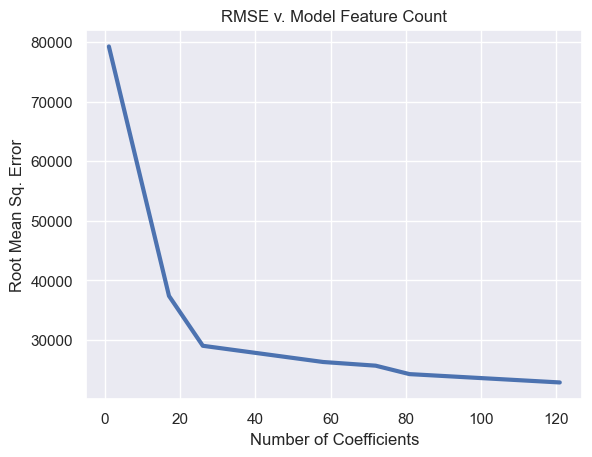

In [37]:
sns.lineplot(data = model_perf, x = num_coefs, y = rmse, linewidth = 3
            ).set(title = "RMSE v. Model Feature Count",
                xlabel = 'Number of Coefficients',
                ylabel = 'Root Mean Sq. Error');

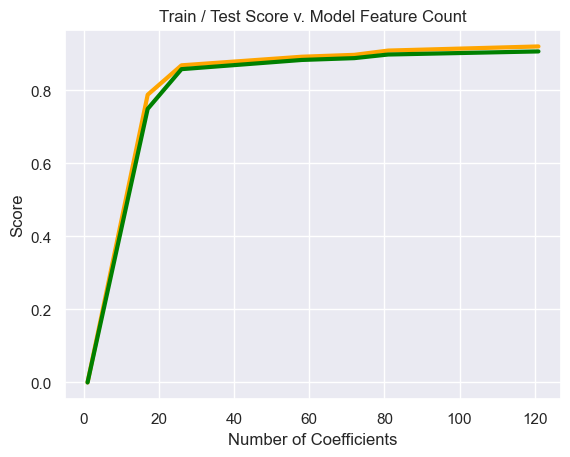

In [38]:
sns.lineplot(data = model_perf, x = num_coefs, y = train_sc, color = 'orange', linewidth = 3
            ).set(title = "Train / Test Score v. Model Feature Count",
                xlabel = 'Number of Coefficients',
                ylabel = 'Score')
sns.lineplot(data = model_perf, x = num_coefs, y = test_sc, color = 'green', linewidth = 3);